In [1]:
# !pip install -r requirements.txt

In [2]:
# !python data_preprocess.py SMD

In [3]:
# !python main.py --dataset='SMD' --max_epoch=20
# !python main.py --max_epoch=1


In [4]:
# !pip install sranodec

In [5]:
# -*- coding: utf-8 -*-
import logging
import os
import pickle
import sys
import time
import warnings
from argparse import ArgumentParser
from pprint import pformat, pprint

import numpy as np
import tensorflow as tf
import matplotlib
# matplotlib.use('TkAgg')
import matplotlib.pyplot as plt
from tfsnippet.examples.utils import MLResults, print_with_title
from tfsnippet.scaffold import VariableSaver
from tfsnippet.utils import get_variables_as_dict, register_config_arguments, Config

from omni_anomaly.eval_methods import pot_eval, bf_search
from omni_anomaly.model import OmniAnomaly
from omni_anomaly.prediction import Predictor
from omni_anomaly.training import Trainer
from omni_anomaly.utils import get_data_dim, get_data, save_z, preprocess


Bad key savefig.frameon in file /opt/conda/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle, line 421 ('savefig.frameon : True')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.3.2/matplotlibrc.template
or from the matplotlib source distribution

Bad key verbose.level in file /opt/conda/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle, line 472 ('verbose.level  : silent      # one of silent, helpful, debug, debug-annoying')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.3.2/matplotlibrc.template
or from the matplotlib source distribution

Bad key verbose.fileo in file /opt/conda/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle, line 473 ('verbose.fileo  : sys.stdout  # a log filename, sys.stdout or sys.stderr')
You probably need to get an updated matplotlibrc file from
https

In [6]:
import pandas as pd

# Read Data

In [7]:
prefix = 'DerbysoftServerMachineDataset/'
train_dir = 'train/'
test_dir = 'test/'
file_name = 'derbysoft_server_machine.csv'


In [8]:
train_df = pd.read_csv(prefix+train_dir+file_name, index_col=0)
train_df.index = pd.to_datetime(train_df.index)

In [9]:
model_list = list(train_df.columns)
model_list

['hse_5xx_count_train_data',
 'hse_fail_rate_train_data',
 'hse_2xx_count_train_data',
 'hse_non_2xx_count_train_data',
 'hse_4xx_count_train_data',
 'hse_resp_time_train_data']

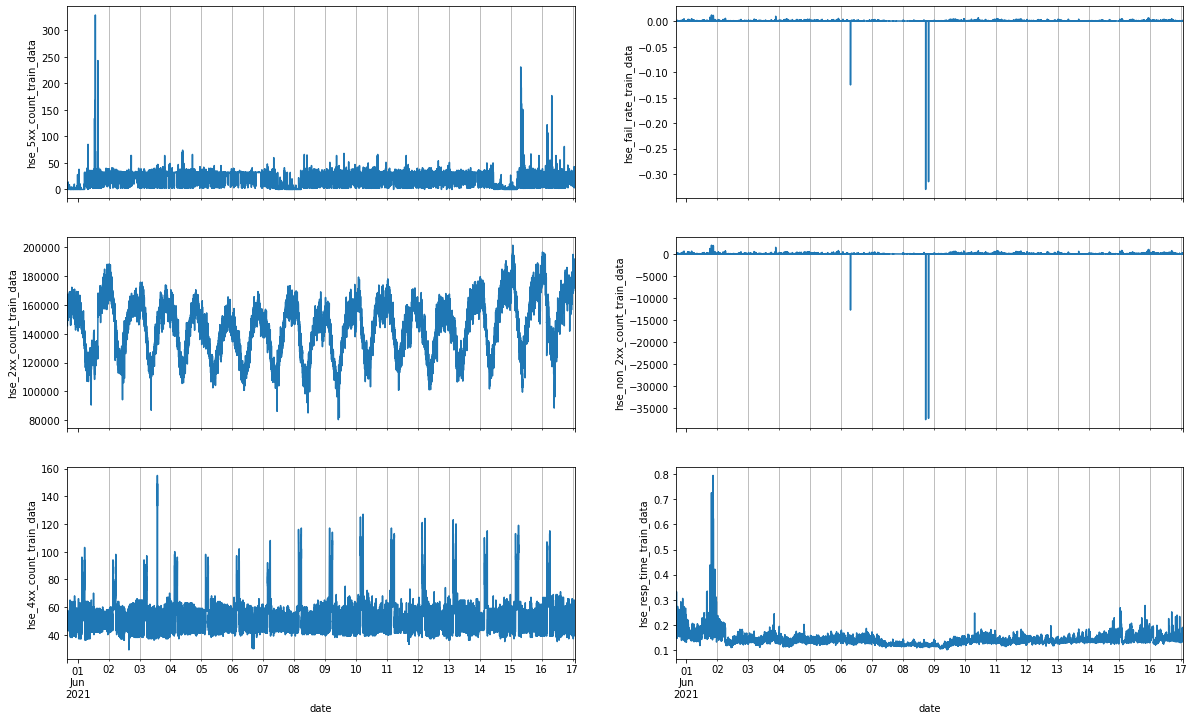

In [10]:
fig, axs = plt.subplots(3, 2, figsize=(20, 12), sharex=True)
axx = axs.ravel()
for i in range(0, len(model_list)):
    train_df[model_list[i]].loc["2021-05-30":"2021-06-18"].plot(ax=axx[i])
    axx[i].set_xlabel("date")    
    axx[i].set_ylabel(model_list[i])   
    axx[i].grid(which='minor', axis='x')
    

In [11]:
test_df = pd.read_csv(prefix+test_dir+file_name, index_col=0)
test_df.index = pd.to_datetime(test_df.index)

In [12]:
train_df_cols = list(train_df.columns)
test_df_cols = [x.replace("train","test") for x in train_df_cols]
test_df_cols

['hse_5xx_count_test_data',
 'hse_fail_rate_test_data',
 'hse_2xx_count_test_data',
 'hse_non_2xx_count_test_data',
 'hse_4xx_count_test_data',
 'hse_resp_time_test_data']

In [13]:
test_df = test_df[test_df_cols]


In [14]:
model_list = list(test_df.columns)
model_list

['hse_5xx_count_test_data',
 'hse_fail_rate_test_data',
 'hse_2xx_count_test_data',
 'hse_non_2xx_count_test_data',
 'hse_4xx_count_test_data',
 'hse_resp_time_test_data']

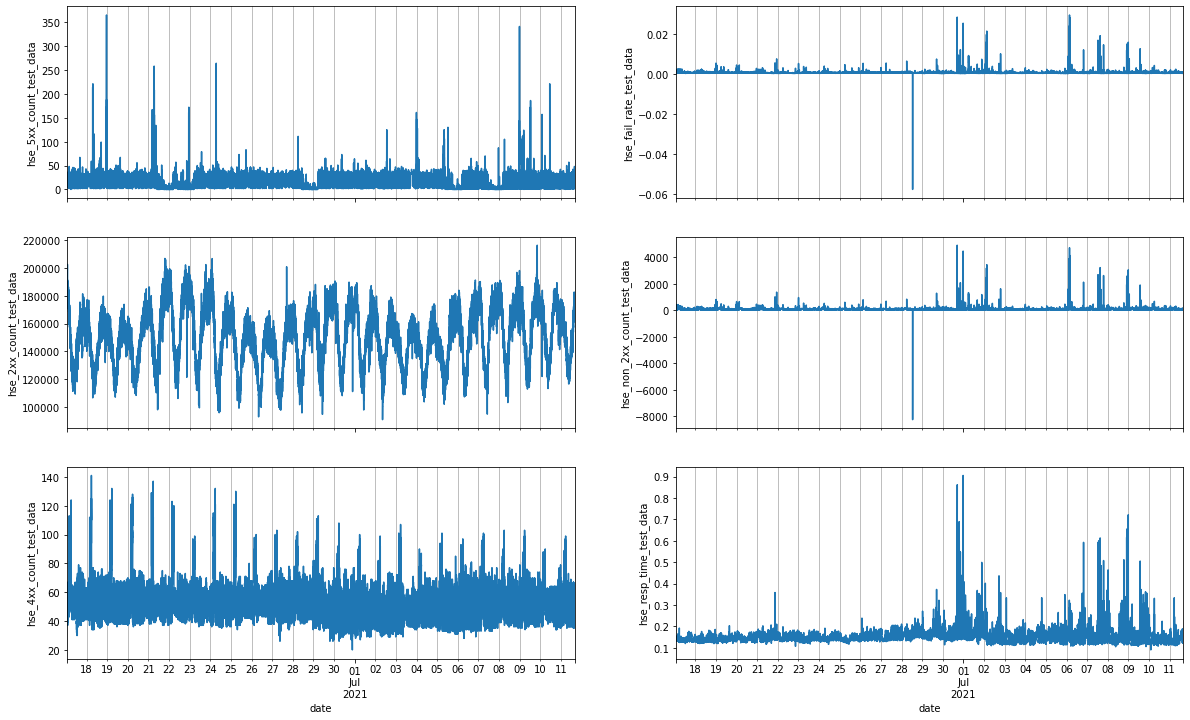

In [15]:
fig, axs = plt.subplots(3, 2, figsize=(20, 12), sharex=True)
axx = axs.ravel()
for i in range(0, len(model_list)):
    test_df[model_list[i]].loc["2021-06-17":"2021-07-12"].plot(ax=axx[i])
    axx[i].set_xlabel("date")    
    axx[i].set_ylabel(model_list[i])   
    axx[i].grid(which='minor', axis='x')

# Robust Anomaly Detection

In [16]:
class ExpConfig(Config):
    # dataset configuration
    dataset = "machine-1-1"
    x_dim = get_data_dim(dataset)

    # model architecture configuration
    use_connected_z_q = True
    use_connected_z_p = True

    # model parameters
    z_dim = 3
    rnn_cell = 'GRU'  # 'GRU', 'LSTM' or 'Basic'
    rnn_num_hidden = 500
    window_length = 100
    dense_dim = 500
    posterior_flow_type = 'nf'  # 'nf' or None
    nf_layers = 20  # for nf
    max_epoch = 10
    train_start = 0
    max_train_size = None  # `None` means full train set
    batch_size = 50
    l2_reg = 0.0001
    initial_lr = 0.001
    lr_anneal_factor = 0.5
    lr_anneal_epoch_freq = 40
    lr_anneal_step_freq = None
    std_epsilon = 1e-4

    # evaluation parameters
    test_n_z = 1
    test_batch_size = 50
    test_start = 0
    max_test_size = None  # `None` means full test set

    # the range and step-size for score for searching best-f1
    # may vary for different dataset
    bf_search_min = -400.
    bf_search_max = 400.
    bf_search_step_size = 1.

    valid_step_freq = 100
    gradient_clip_norm = 10.

    early_stop = True  # whether to apply early stop method

    # pot parameters
    # recommend values for `level`:
    # SMAP: 0.07
    # MSL: 0.01
    # SMD group 1: 0.0050
    # SMD group 2: 0.0075
    # SMD group 3: 0.0001
    level = 0.005

    # outputs config
    save_z = False  # whether to save sampled z in hidden space
    get_score_on_dim = False  # whether to get score on dim. If `True`, the score will be a 2-dim ndarray
    save_dir = 'model'
    restore_dir = None  # If not None, restore variables from this dir
    result_dir = 'result'  # Where to save the result file
    train_score_filename = 'train_score.pkl'
    test_score_filename = 'test_score.pkl'
    
    

In [17]:
train_df.shape

(23615, 6)

In [18]:
test_df.shape

(35423, 6)

In [19]:
train_df.head()

,hse_5xx_count_train_data,hse_fail_rate_train_data,hse_2xx_count_train_data,hse_non_2xx_count_train_data,hse_4xx_count_train_data,hse_resp_time_train_data
ds,,,,,,
2021-05-31 16:01:00,3,0.000543,145522,79,47,0.196870
2021-05-31 16:02:00,3,0.000348,152220,53,45,0.179332
2021-05-31 16:03:00,3,0.000611,147327,90,57,0.162431
2021-05-31 16:04:00,3,0.000894,149800,134,43,0.189796
2021-05-31 16:05:00,3,0.000351,165144,58,50,0.203034


In [20]:
# get config obj
config = ExpConfig()

# parse the arguments
# arg_parser = ArgumentParser()
# register_config_arguments(config, arg_parser)
# arg_parser.parse_args(sys.argv[1:])

config.max_epoch = 100
config.train_start = 0
config.max_train_size = 20000
config.x_dim = train_df.shape[1]
config.restore_dir = 'model'

print_with_title('Configurations', pformat(config.to_dict()), after='\n')

# open the result object and prepare for result directories if specified
results = MLResults(config.result_dir)
results.save_config(config)  # save experiment settings for review
results.make_dirs(config.save_dir, exist_ok=True)
# with warnings.catch_warnings():
#     # suppress DeprecationWarning from NumPy caused by codes in TensorFlow-Probability
#     warnings.filterwarnings("ignore", category=DeprecationWarning, module='numpy')
#     main()

Configurations
{'batch_size': 50,
 'bf_search_max': 400.0,
 'bf_search_min': -400.0,
 'bf_search_step_size': 1.0,
 'dataset': 'machine-1-1',
 'dense_dim': 500,
 'early_stop': True,
 'get_score_on_dim': False,
 'gradient_clip_norm': 10.0,
 'initial_lr': 0.001,
 'l2_reg': 0.0001,
 'level': 0.005,
 'lr_anneal_epoch_freq': 40,
 'lr_anneal_factor': 0.5,
 'lr_anneal_step_freq': None,
 'max_epoch': 100,
 'max_test_size': None,
 'max_train_size': 20000,
 'nf_layers': 20,
 'posterior_flow_type': 'nf',
 'restore_dir': 'model',
 'result_dir': 'result',
 'rnn_cell': 'GRU',
 'rnn_num_hidden': 500,
 'save_dir': 'model',
 'save_z': False,
 'std_epsilon': 0.0001,
 'test_batch_size': 50,
 'test_n_z': 1,
 'test_score_filename': 'test_score.pkl',
 'test_start': 0,
 'train_score_filename': 'train_score.pkl',
 'train_start': 0,
 'use_connected_z_p': True,
 'use_connected_z_q': True,
 'valid_step_freq': 100,
 'window_length': 100,
 'x_dim': 6,
 'z_dim': 3}



In [21]:
logging.basicConfig(
    level='INFO',
    format='%(asctime)s [%(levelname)s] %(name)s: %(message)s'
)

# # prepare the data
# (x_train, _), (x_test, y_test) = \
#     get_data(config.dataset, config.max_train_size, config.max_test_size, train_start=config.train_start,
#              test_start=config.test_start)

if config.max_train_size is None:
    train_end = None
else:
    train_end = config.train_start + config.max_train_size

train_data = train_df.values.reshape((-1, config.x_dim))[config.train_start:train_end, :]
x_train = preprocess(train_data)


Data normalized


In [22]:
import sranodec as anom

In [23]:
# x_train[x_train<0] = np.nan


# less than period
amp_window_size=24
# (maybe) as same as period
series_window_size=24
# a number enough larger than period
score_window_size=100

spec = anom.Silency(amp_window_size, series_window_size, score_window_size)

for i in range(x_train.shape[1]):
    score = spec.generate_anomaly_score(x_train[:,i])
    index_changes = np.where(score > np.percentile(score, 99))[0]
    x_train[index_changes,i] = np.nan
    df = pd.DataFrame(x_train[:,i])
    df = df.fillna(method="ffill")
#     df = df.fillna(0)
    x_train[:,i] = df.values.ravel()
    

/opt/conda/lib/python3.6/site-packages/sranodec/util.py:31: RuntimeWarning: invalid value encountered in true_divide
  slope = [(last_value - v) / i for (i, v) in enumerate(values[::-1])]
/opt/conda/lib/python3.6/site-packages/sranodec/util.py:31: RuntimeWarning: invalid value encountered in true_divide
  slope = [(last_value - v) / i for (i, v) in enumerate(values[::-1])]
/opt/conda/lib/python3.6/site-packages/sranodec/util.py:31: RuntimeWarning: invalid value encountered in true_divide
  slope = [(last_value - v) / i for (i, v) in enumerate(values[::-1])]
/opt/conda/lib/python3.6/site-packages/sranodec/util.py:31: RuntimeWarning: invalid value encountered in true_divide
  slope = [(last_value - v) / i for (i, v) in enumerate(values[::-1])]
/opt/conda/lib/python3.6/site-packages/sranodec/util.py:31: RuntimeWarning: invalid value encountered in true_divide
  slope = [(last_value - v) / i for (i, v) in enumerate(values[::-1])]
/opt/conda/lib/python3.6/site-packages/sranodec/util.py:31: 

In [ ]:
# construct the model under `variable_scope` named 'model'
with tf.variable_scope('model', reuse=tf.AUTO_REUSE) as model_vs:
    model = OmniAnomaly(config=config, name="model")

    # construct the trainer
    trainer = Trainer(model=model,
                      model_vs=model_vs,
                      max_epoch=config.max_epoch,
                      batch_size=config.batch_size,
                      valid_batch_size=config.test_batch_size,
                      initial_lr=config.initial_lr,
                      lr_anneal_epochs=config.lr_anneal_epoch_freq,
                      lr_anneal_factor=config.lr_anneal_factor,
                      grad_clip_norm=config.gradient_clip_norm,
                      valid_step_freq=config.valid_step_freq)

    # construct the predictor
    predictor = Predictor(model, batch_size=config.batch_size, n_z=config.test_n_z,
                          last_point_only=True)

    with tf.Session().as_default():

#         if config.restore_dir is not None:
#             # Restore variables from `save_dir`.
#             saver = VariableSaver(get_variables_as_dict(model_vs), config.restore_dir)
#             saver.restore()

        if config.max_epoch > 0:
            # train the model
            train_start = time.time()
            best_valid_metrics = trainer.fit(x_train)
            train_time = (time.time() - train_start) / config.max_epoch
            best_valid_metrics.update({
                'train_time': train_time
            })
        else:
            best_valid_metrics = {}

        # get score of train set for POT algorithm
#         train_score, train_z, train_pred_speed = predictor.get_score(x_train)
#         if config.train_score_filename is not None:
#             with open(os.path.join(config.result_dir, config.train_score_filename), 'wb') as file:
#                 pickle.dump(train_score, file)
#         if config.save_z:
#             save_z(train_z, 'train_z')

        if config.save_dir is not None:
            # save the variables
            var_dict = get_variables_as_dict(model_vs)
            saver = VariableSaver(var_dict, config.save_dir)
            saver.save()
        print('=' * 30 + 'result' + '=' * 30)
        pprint(best_valid_metrics)
        

Trainable Parameters                                            (2,527,676 in total)
------------------------------------------------------------------------------------
model/q_z_given_x/rnn_q_z/rnn/gru_cell/gates/kernel             (506, 1000)  506,000
model/q_z_given_x/rnn_q_z/rnn/gru_cell/gates/bias               (1000,)        1,000
model/q_z_given_x/rnn_q_z/rnn/gru_cell/candidate/kernel         (506, 500)   253,000
model/q_z_given_x/rnn_q_z/rnn/gru_cell/candidate/bias           (500,)           500
model/q_z_given_x/rnn_q_z/dense/kernel                          (500, 500)   250,000
model/q_z_given_x/rnn_q_z/dense/bias                            (500,)           500
model/q_z_given_x/rnn_q_z/dense_1/kernel                        (500, 500)   250,000
model/q_z_given_x/rnn_q_z/dense_1/bias                          (500,)           500
model/vae/variational/z_mean/kernel                             (503, 3)       1,509
model/vae/variational/z_mean/bias                               (

# Predict Train Data

In [34]:
train_df.iloc[0:20000].tail()

,hse_5xx_count_train_data,hse_fail_rate_train_data,hse_2xx_count_train_data,hse_non_2xx_count_train_data,hse_4xx_count_train_data,hse_resp_time_train_data
ds,,,,,,
2021-06-14 13:16:00,1,0.000403,151366,61,56,0.145758
2021-06-14 13:17:00,1,0.000302,145743,44,44,0.144448
2021-06-14 13:18:00,1,0.000351,145373,51,49,0.149824
2021-06-14 13:19:00,1,0.000407,142461,58,57,0.145274
2021-06-14 13:20:00,2,0.000374,149629,56,53,0.144876


In [26]:
# train_data = train_df[''].values.reshape((-1, config.x_dim))
# x_train = preprocess(train_data)


In [27]:
# tf.keras.backend.clear_session()

with tf.variable_scope('model', reuse=tf.AUTO_REUSE) as model_vs:
    model = OmniAnomaly(config=config, name="model")
    # construct the predictor
    predictor = Predictor(model, batch_size=config.batch_size, n_z=config.test_n_z,
                          last_point_only=True)
    with tf.Session().as_default():
        
        if config.restore_dir is not None:
            # Restore variables from `save_dir`.
            saver = VariableSaver(get_variables_as_dict(model_vs), config.restore_dir)
            saver.restore()
            
            train_score, _, _ = predictor.get_score(x_train)
            

INFO:tensorflow:Restoring parameters from /root/omni-anomaly-detection/OmniAnomaly/model/variables.dat


2021-07-13 01:51:46,942 [INFO] tensorflow: Restoring parameters from /root/omni-anomaly-detection/OmniAnomaly/model/variables.dat


------------------------------ testing ------------------------------


In [32]:
len(x_train)

20000

In [35]:
train_score_df = pd.DataFrame()
train_score_df['anomaly_score'] = -train_score
train_score_df.index = train_df['2021-05-31 16:01:00':'2021-06-14 13:20:00'].iloc[config.window_length-1:,0].index

In [36]:
# train_score_df

In [37]:
model_list = list(train_df.columns)

model_name:  hse_5xx_count_train_data
model_name:  hse_fail_rate_train_data
model_name:  hse_2xx_count_train_data
model_name:  hse_non_2xx_count_train_data
model_name:  hse_4xx_count_train_data
model_name:  hse_resp_time_train_data


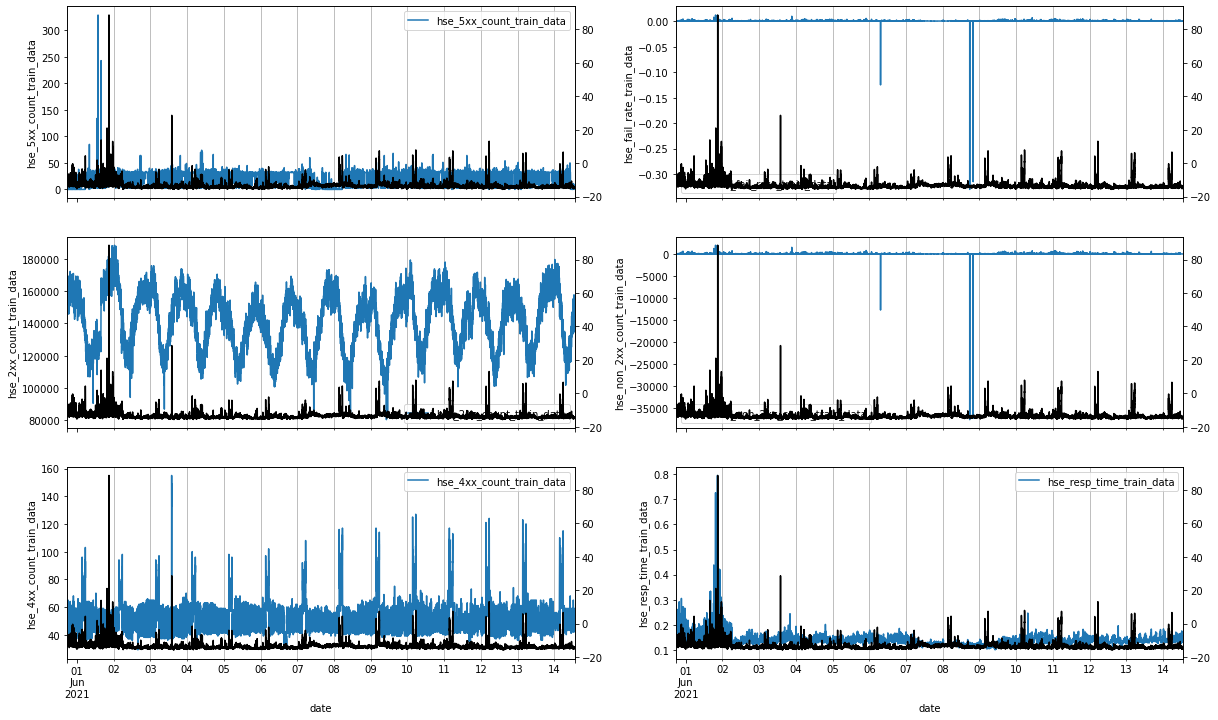

In [38]:
fig, axs = plt.subplots(3, 2, figsize=(20, 12), sharex=True)
axx = axs.ravel()
for i in range(0, len(model_list)):
    model_name = model_list[i]
    print('model_name: ', model_name)
    
    axx_2 = axx[i].twinx()           # 做镜像处理
    anomaly_y = train_score_df
    anomaly_y.plot(ax=axx_2, color='black', legend = False)
    origin_y = train_df[model_name].loc[train_score_df.index]
    origin_y.plot(legend = True, ax=axx[i])
    
    
#     train_df[model_list[i]].loc["2021-04-01":"2021-05-07"].plot(ax=axx[i])
    axx[i].set_xlabel("date")    
    axx[i].set_ylabel(model_list[i])   
    axx[i].grid(which='minor', axis='x')
    

# Calculate Threshold

In [39]:
threshold = np.mean(train_score_df['anomaly_score'])+2*np.std(train_score_df['anomaly_score'])
threshold

# threshold = 100

-8.764188289642334

In [40]:
# threshold = 20

In [41]:
# train_df.head()

# Plot Anomalies

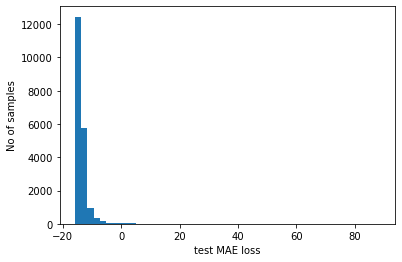

Number of anomaly samples:  609
Indices of anomaly samples:  (array([   36,    37,    38,    60,    61,    62,   118,   121,   122,
         123,   124,   134,   135,   137,   184,   186,   187,   188,
         189,   192,   193,   194,   195,   196,   197,   198,   201,
         202,   203,   204,   205,   206,   207,   208,   209,   256,
         261,   262,   266,   268,   269,   271,   272,   273,   328,
         329,   330,   331,   337,   341,   460,   463,   465,   466,
         467,   471,   535,   536,   579,   582,   627,   636,   645,
         657,   660,   661,   664,   669,   672,   673,   675,   678,
         681,   682,   699,   701,   702,   703,   704,   705,   706,
         707,   708,   709,  1108,  1135,  1137,  1164,  1165,  1166,
        1167,  1168,  1169,  1171,  1184,  1187,  1194,  1198,  1199,
        1200,  1203,  1204,  1205,  1206,  1207,  1208,  1209,  1211,
        1250,  1251,  1253,  1274,  1278,  1281,  1282,  1319,  1320,
        1321,  1322,  1323, 

In [42]:
# test_mae_loss = test_mae_loss.reshape((-1))
train_mae_loss = np.copy(train_score_df['anomaly_score'])
plt.hist(train_mae_loss, bins=50)
plt.xlabel("test MAE loss")
plt.ylabel("No of samples")
plt.show()

# Detect all the samples which are anomalies.
anomalies = (train_mae_loss > threshold).tolist()
print("Number of anomaly samples: ", np.sum(anomalies))
print("Indices of anomaly samples: ", np.where(anomalies))



In [43]:
TIME_STEPS = 30

In [44]:
# data i is an anomaly if samples [(i - timesteps + 1) to (i)] are anomalies
anomalous_data_indices = []
# TIME_STEPS = 288
for data_idx in range(TIME_STEPS - 1, len(train_score_df) - TIME_STEPS + 1):
    time_series = range(data_idx - TIME_STEPS + 1, data_idx)
    # print(np.sum([anomalies[j] for j in time_series]))
    # if all([anomalies[j] for j in time_series]):
    # if np.sum([anomalies[j] for j in time_series])>30:
    if np.sum([anomalies[j] for j in time_series])/TIME_STEPS>0.5:

        anomalous_data_indices.append(data_idx)



In [45]:
model_list = list(train_df.columns)

model_name:  hse_5xx_count_train_data
model_name:  hse_fail_rate_train_data
model_name:  hse_2xx_count_train_data
model_name:  hse_non_2xx_count_train_data
model_name:  hse_4xx_count_train_data
model_name:  hse_resp_time_train_data


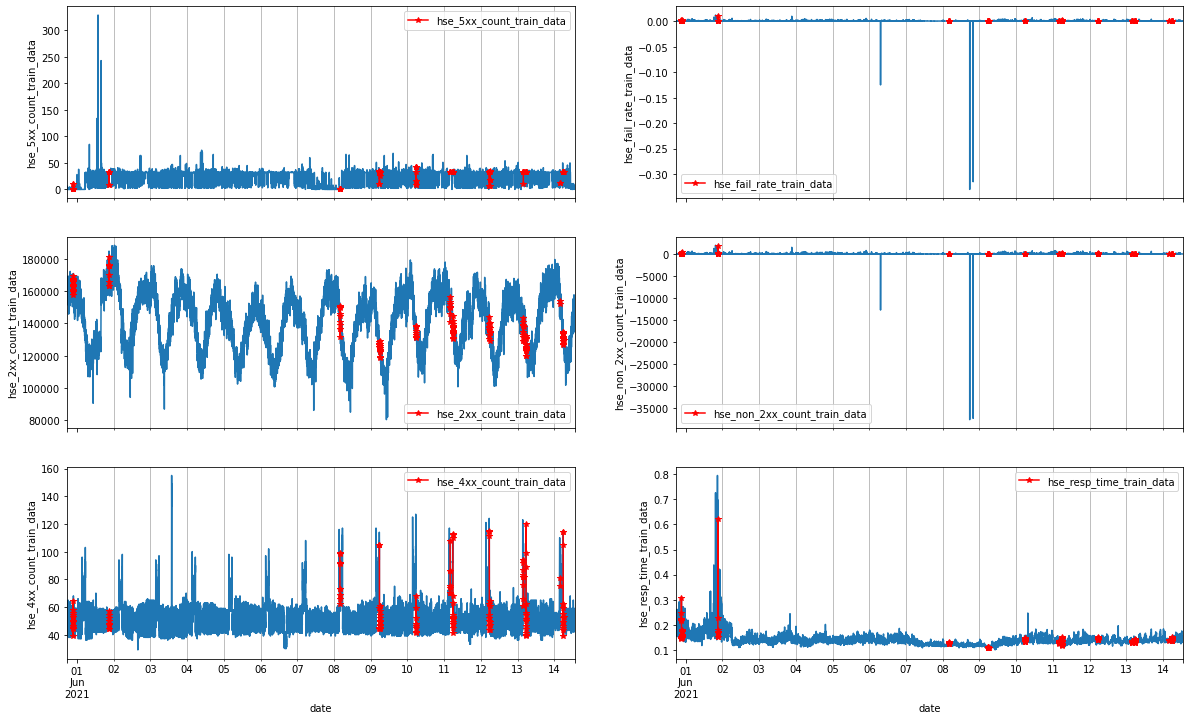

In [46]:

fig, axs = plt.subplots(3, 2, figsize=(20, 12), sharex=True)
axx = axs.ravel()
for i in range(0, len(model_list)):
    model_name = model_list[i]
    print('model_name: ', model_name)

#     anomalous_data_indices = anomalous_data_indices_dict[model_id]
    
    train_df_index_set = set(range(len(train_df.loc[train_score_df.index])))
    anomalous_data_indices_set = set(anomalous_data_indices)
    nan_set = train_df_index_set - anomalous_data_indices_set
    
    df_subset = train_df.loc[train_score_df.index].copy()
    df_subset.iloc[list(nan_set), : ] = np.nan
    
#     df_subset = test_df.iloc[anomalous_data_indices, :]

    # timeseries[i].loc["2020-08-30":"2020-11-5"].plot(ax=axx[i])
    # model_id = 'node_memory_MemAvailable_rate'
    train_df[model_name].loc[train_score_df.index].plot(ax=axx[i])
    if len(anomalous_data_indices)>0:
        df_temp = df_subset[[model_name]].loc[train_score_df.index]
        df_temp.plot(ax=axx[i], color='r',label='anomalies', marker='*')

    axx[i].set_xlabel("date")    
    axx[i].set_ylabel(model_list[i])   
    axx[i].grid(which='minor', axis='x')

# Predict Test Data

In [47]:
test_df_cols = list(train_df.columns)
test_df_cols = [x.replace("train","test") for x in test_df_cols]
test_df_cols

['hse_5xx_count_test_data',
 'hse_fail_rate_test_data',
 'hse_2xx_count_test_data',
 'hse_non_2xx_count_test_data',
 'hse_4xx_count_test_data',
 'hse_resp_time_test_data']

In [48]:
test_df = test_df[test_df_cols]

In [49]:
test_df.head()

,hse_5xx_count_test_data,hse_fail_rate_test_data,hse_2xx_count_test_data,hse_non_2xx_count_test_data,hse_4xx_count_test_data,hse_resp_time_test_data
ds,,,,,,
2021-06-17 01:37:00,33,0.000307,182063,56,54,0.136451
2021-06-17 01:38:00,31,0.000483,186118,90,57,0.136155
2021-06-17 01:39:00,31,0.000232,176970,41,40,0.134307
2021-06-17 01:40:00,31,0.000827,184780,153,53,0.143119
2021-06-17 01:41:00,31,0.000802,179308,144,65,0.153245


In [50]:
test_data = test_df['2021-06-16 00:00:00':'2021-07-12 00:00:00']
test_data

,hse_5xx_count_test_data,hse_fail_rate_test_data,hse_2xx_count_test_data,hse_non_2xx_count_test_data,hse_4xx_count_test_data,hse_resp_time_test_data
ds,,,,,,
2021-06-17 01:37:00,33,0.000307,182063,56,54,0.136451
2021-06-17 01:38:00,31,0.000483,186118,90,57,0.136155
2021-06-17 01:39:00,31,0.000232,176970,41,40,0.134307
2021-06-17 01:40:00,31,0.000827,184780,153,53,0.143119
2021-06-17 01:41:00,31,0.000802,179308,144,65,0.153245
...,...,...,...,...,...,...
2021-07-11 15:55:00,32,0.000281,174351,49,47,0.144674
2021-07-11 15:56:00,32,0.000281,174351,49,47,0.144674
2021-07-11 15:57:00,32,0.000277,169681,47,46,0.134750


In [51]:

test_data = test_df['2021-06-16 00:00:00':'2021-07-12 00:00:00'].values.reshape((-1, config.x_dim))
x_test = preprocess(test_data)


Data normalized


In [52]:
x_test[x_test<0] = np.nan


In [53]:
# tf.keras.backend.clear_session()

with tf.variable_scope('model', reuse=tf.AUTO_REUSE) as model_vs:
    model = OmniAnomaly(config=config, name="model")
    # construct the predictor
    predictor = Predictor(model, batch_size=config.batch_size, n_z=config.test_n_z,
                          last_point_only=True)
    with tf.Session().as_default():

        if config.restore_dir is not None:
            # Restore variables from `save_dir`.
            saver = VariableSaver(get_variables_as_dict(model_vs), config.restore_dir)
            saver.restore()

            test_score, _, _ = predictor.get_score(x_test)
    

INFO:tensorflow:Restoring parameters from /root/omni-anomaly-detection/OmniAnomaly/model/variables.dat


2021-07-13 01:56:32,787 [INFO] tensorflow: Restoring parameters from /root/omni-anomaly-detection/OmniAnomaly/model/variables.dat


------------------------------ testing ------------------------------


In [54]:
len(test_score)

35324

In [55]:
np.shape(x_test)

(35423, 6)

In [56]:
test_score_df = pd.DataFrame()
test_score_df['anomaly_score'] = -test_score
test_score_df.index = test_df['2021-06-16 00:00:00':'2021-07-12 00:00:00'].iloc[config.window_length-1:,0].index

In [57]:
model_list = list(test_df.columns)

model_name:  hse_5xx_count_test_data
model_name:  hse_fail_rate_test_data
model_name:  hse_2xx_count_test_data
model_name:  hse_non_2xx_count_test_data
model_name:  hse_4xx_count_test_data
model_name:  hse_resp_time_test_data


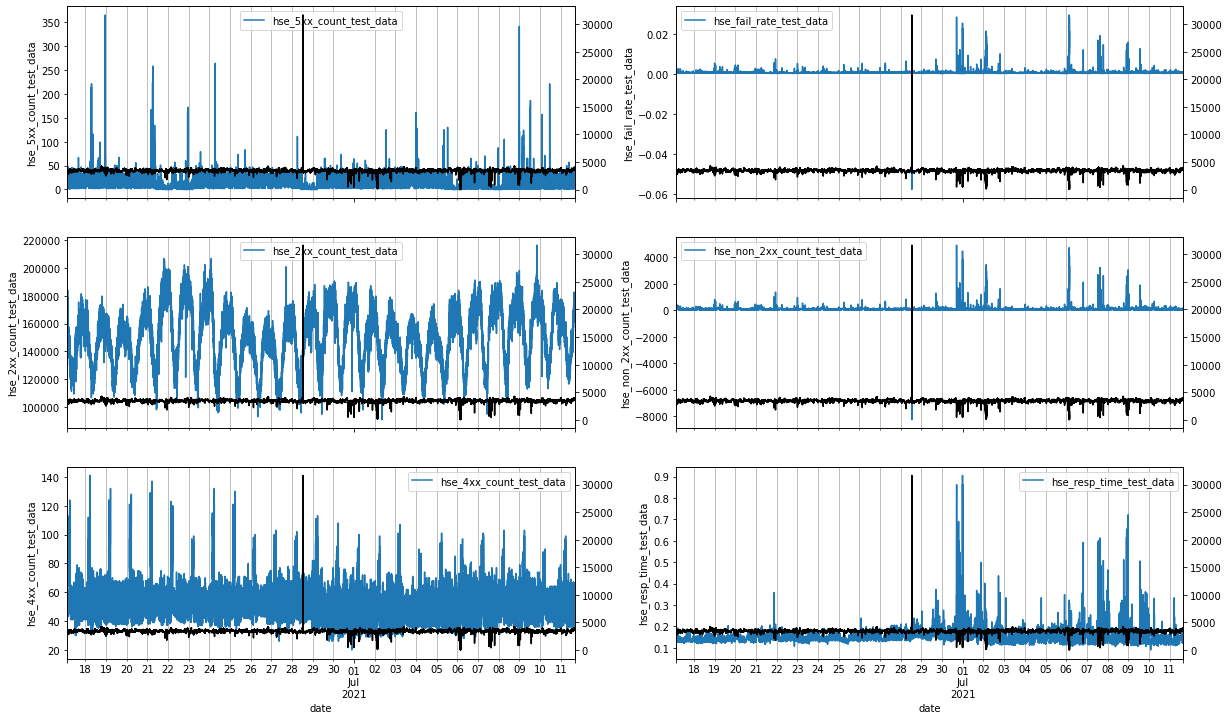

In [58]:
fig, axs = plt.subplots(3, 2, figsize=(20, 12), sharex=True)
axx = axs.ravel()
for i in range(0, len(model_list)):
    model_name = model_list[i]
    print('model_name: ', model_name)
    
    axx_2 = axx[i].twinx()           # 做镜像处理
    anomaly_y = test_score_df
    anomaly_y.plot(ax=axx_2, color='black', legend = False)
    origin_y = test_df[model_name].loc[test_score_df.index]
    origin_y.plot(legend = True, ax=axx[i])

    
#     train_df[model_list[i]].loc["2021-04-01":"2021-05-07"].plot(ax=axx[i])
    axx[i].set_xlabel("date")    
    axx[i].set_ylabel(model_list[i])   
    axx[i].grid(which='minor', axis='x')
    

In [59]:
# anomaly_y

# Plot Anomalies

In [76]:
threshold = np.mean(test_score_df['anomaly_score'])+3*np.std(test_score_df['anomaly_score'])
# threshold = 300


In [77]:
threshold

4357.416564941406

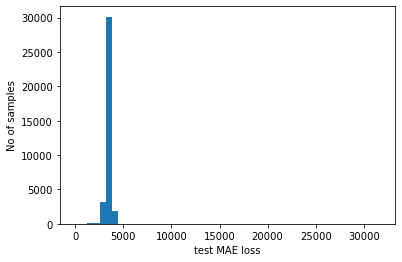

Number of anomaly samples:  1
Indices of anomaly samples:  (array([16418]),)


In [78]:
# test_mae_loss = test_mae_loss.reshape((-1))
test_mae_loss = np.copy(test_score_df['anomaly_score'])
plt.hist(test_mae_loss, bins=50)
plt.xlabel("test MAE loss")
plt.ylabel("No of samples")
plt.show()

# Detect all the samples which are anomalies.
anomalies = (test_mae_loss > threshold).tolist()
print("Number of anomaly samples: ", np.sum(anomalies))
print("Indices of anomaly samples: ", np.where(anomalies))



In [79]:
TIME_STEPS = 30

In [80]:
# len(test_df)

In [81]:
# data i is an anomaly if samples [(i - timesteps + 1) to (i)] are anomalies
anomalous_data_indices = []
# TIME_STEPS = 288
for data_idx in range(TIME_STEPS - 1, len(test_score_df) - TIME_STEPS + 1):
    time_series = range(data_idx - TIME_STEPS + 1, data_idx)
    # print(np.sum([anomalies[j] for j in time_series]))
    # if all([anomalies[j] for j in time_series]):
    # if np.sum([anomalies[j] for j in time_series])>30:
    if np.sum([anomalies[j] for j in time_series])/TIME_STEPS>0.5:

        anomalous_data_indices.append(data_idx)



model_name:  hse_5xx_count_test_data
model_name:  hse_fail_rate_test_data
model_name:  hse_2xx_count_test_data
model_name:  hse_non_2xx_count_test_data
model_name:  hse_4xx_count_test_data
model_name:  hse_resp_time_test_data


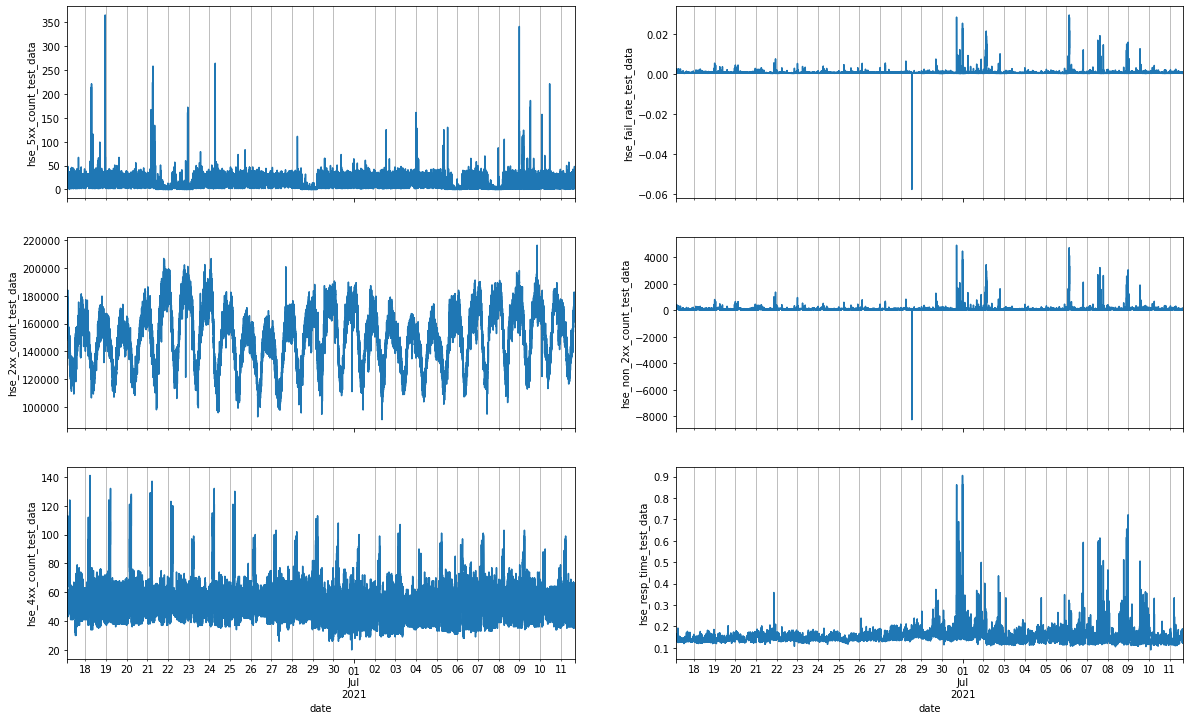

In [82]:

fig, axs = plt.subplots(3, 2, figsize=(20, 12), sharex=True)
axx = axs.ravel()
for i in range(0, len(model_list)):
    model_name = model_list[i]
    print('model_name: ', model_name)

#     anomalous_data_indices = anomalous_data_indices_dict[model_id]
    
    test_df_index_set = set(range(len(test_df.loc[test_score_df.index])))
    anomalous_data_indices_set = set(anomalous_data_indices)
    nan_set = test_df_index_set - anomalous_data_indices_set
    
    df_subset = test_df.loc[test_score_df.index].copy()
    df_subset.iloc[list(nan_set), : ] = np.nan
    
#     df_subset = test_df.iloc[anomalous_data_indices, :]

    # timeseries[i].loc["2020-08-30":"2020-11-5"].plot(ax=axx[i])
    # model_id = 'node_memory_MemAvailable_rate'
    test_df[model_name].loc[test_score_df.index].plot(ax=axx[i])
    if len(anomalous_data_indices)>0:
        df_temp = df_subset[[model_name]].loc[test_score_df.index]
        df_temp.plot(ax=axx[i], color='r',label='anomalies', marker='*')
    
    axx[i].axvspan('2021-05-23', '2021-05-25', alpha=0.2, color='red')

    axx[i].set_xlabel("date")    
    axx[i].set_ylabel(model_list[i])   
    axx[i].grid(which='minor', axis='x')
    

In [83]:
df_temp[df_temp['hse_resp_time_test_data'].notna()].loc['2021-05-16':'2021-05-20']


,hse_resp_time_test_data
ds,


In [68]:
print(pd.datetime.now())


2021-07-13 01:59:48.474421


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime instead.
  """Entry point for launching an IPython kernel.
